In [1]:
import numpy as np
import pandas as pd
import os

# visualizations
import matplotlib.pyplot as plt

# data stratifying and splitting
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

# preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest
from sklearn.compose import ColumnTransformer

# class imbalance
from imblearn.pipeline import make_pipeline as imb_make_pipeline
from imblearn.under_sampling import RandomUnderSampler

# algorithms/models
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

# model evaluation
from imblearn.metrics import classification_report_imbalanced
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score

# performance check
import time
import warnings

warnings.filterwarnings("ignore")
from sklearn.base import TransformerMixin
class DenseTransformer(TransformerMixin):
    def fit(self, X, y=None, **fit_params):
        return self
    def transform(self, X, y=None, **fit_params):
        return X.todense()
from joblib import dump


In [2]:
# reading the final dataset
path_to_csv = ("clean_data_3.csv")
personality_data = pd.read_csv(path_to_csv)

In [3]:
# checking top records
personality_data.head(2)

,type,is_Extrovert,is_Sensing,is_Thinking,is_Judging,posts,clean_posts,compound_sentiment,pos_sentiment,neg_sentiment,...,em,colons,emojis,word_count,unique_words,post_length_var,upper,link_count,ellipses,img_count
0,INFJ,0,0,0,1,'When asked of the things you wish you did ear...,"'when asked thing wish earlier (' ), find answ...",0.99985,0.530909,0.211268,...,0.22,0.32,0.08,30.98,14.92,78.414931,1.46,0.04,0.62,0.0
1,INFJ,0,0,0,1,'I love both and they are equally important to...,' love equally important . music window soul. ...,0.99995,0.747273,0.222535,...,0.36,0.14,0.00,28.58,12.72,160.744400,1.62,0.02,0.04,0.0


In [4]:
# setting X to clean_posts, compound sentiment score, pos tags and various other counts
X = personality_data[
    [
        "clean_posts",
        "compound_sentiment",
        "ADJ_avg",
        "ADP_avg",
        "ADV_avg",
        "CONJ_avg",
        "DET_avg",
        "NOUN_avg",
        "NUM_avg",
        "PRT_avg",
        "PRON_avg",
        "VERB_avg",
        "qm",
        "em",
        "colons",
        "emojis",
        "word_count",
        "unique_words",
        "upper",
        "link_count",
        "ellipses",
        "img_count",
    ]
]

# setting y to four target classes -> is_Extrovert, is_Sensing, is_Thinking, is_Judging
y = personality_data.iloc[:, 1:5]

# ensuring that X and y row count matches
print(X.shape)
print(y.shape)

(8588, 22)
(8588, 4)


In [5]:
additional_stopwords = [
    "hey",
    "hello",
    "briggs",
    "cat",
    "car",
    "mbti",
    "soup",
    "tea",
    "sport",
    "snow",
    "christmas",
]

In [6]:
# preprocessing steps for selecting best k columns/features from counts & scores and for vectorizing words

counts_n_scores = [
    "compound_sentiment",
    "ADJ_avg",
    "ADP_avg",
    "ADV_avg",
    "CONJ_avg",
    "DET_avg",
    "NOUN_avg",
    "NUM_avg",
    "PRT_avg",
    "PRON_avg",
    "VERB_avg",
    "qm",
    "em",
    "colons",
    "emojis",
    "word_count",
    "unique_words",
    "upper",
    "link_count",
    "ellipses",
    "img_count",
]

# for selecting k best features from features other than words
best_k_features = make_pipeline(MinMaxScaler(), SelectKBest(f_classif, k=10))

# setting up preprocessing for TF-IDF vectorizer
preprocesser_tf = ColumnTransformer(
    transformers=[
        (
            "tfidf",
            TfidfVectorizer(min_df=25, max_df=0.85, stop_words=additional_stopwords),
            "clean_posts",
        ),
        ("selectbest", best_k_features, counts_n_scores),
    ],
    remainder="passthrough",
)

# setting up preprocessing for COUNT vectorizer
preprocesser_ct = ColumnTransformer(
    transformers=[
        (
            "ct_vect",
            CountVectorizer(min_df=25, max_df=0.85, stop_words=additional_stopwords),
            "clean_posts",
        ),
        ("selectbest", best_k_features, counts_n_scores),
    ],
    remainder="passthrough",
)

In [7]:
# setting up the personality dictionary for printing scores for each class
mbti_type = {
    "is_Extrovert": "Extrovert vs Introvert",
    "is_Sensing": "Sensing vs Intuition",
    "is_Thinking": "Thinking vs Feeling",
    "is_Judging": "Judging vs Perceiving",
}

# function to build the model for predicting each of the 4 target classes
def build_model(model, X, target, vectorizer_name):

    for col in target.columns:

        print(f"\n{mbti_type[col]}")
        target = y[col]

        X_train, X_test, y_train, y_test = train_test_split(
            X, target, test_size=0.2, random_state=42, stratify=target
        )

        # model training
        model.fit(X_train, y_train)

        # y_hat
        y_pred = model.predict(X_test)

        # y_probability
        y_proba = model.predict_proba(X_test)[:, 1]

        # precision recall score
        average_precision = average_precision_score(y_test, y_proba)

        # model evaluation
        print(
            f"Geometric Mean Score: {geometric_mean_score(y_test, y_pred, average='weighted'):.2f}"
        )
        print(f"ROC-AUC Score: {roc_auc_score(y_test, y_proba):.2f}")
        print(f"Average Precision-Recall Score: {average_precision:.2f}")
        print(classification_report_imbalanced(y_test, y_pred))


In [8]:
%%time

tfidf_logistic_regression = imb_make_pipeline(
    preprocesser_tf, RandomUnderSampler(), LogisticRegressionCV()
)
build_model(tfidf_logistic_regression, X, y, "tfidf")


Extrovert vs Introvert
Geometric Mean Score: 0.66
ROC-AUC Score: 0.74
Average Precision-Recall Score: 0.47
                   pre       rec       spe        f1       geo       iba       sup

          0       0.87      0.67      0.65      0.76      0.66      0.44      1322
          1       0.37      0.65      0.67      0.47      0.66      0.44       396

avg / total       0.75      0.67      0.66      0.69      0.66      0.44      1718


Sensing vs Intuition
Geometric Mean Score: 0.69
ROC-AUC Score: 0.77
Average Precision-Recall Score: 0.36
                   pre       rec       spe        f1       geo       iba       sup

          0       0.94      0.66      0.73      0.78      0.69      0.48      1481
          1       0.26      0.73      0.66      0.38      0.69      0.48       237

avg / total       0.84      0.67      0.72      0.72      0.69      0.48      1718


Thinking vs Feeling
Geometric Mean Score: 0.78
ROC-AUC Score: 0.87
Average Precision-Recall Score: 0.84
           

In [9]:
%%time
ct_logistic_regression = imb_make_pipeline(
    preprocesser_ct, RandomUnderSampler(), LogisticRegressionCV()
)
build_model(ct_logistic_regression, X, y, "ct_vect")


Extrovert vs Introvert
Geometric Mean Score: 0.65
ROC-AUC Score: 0.71
Average Precision-Recall Score: 0.41
                   pre       rec       spe        f1       geo       iba       sup

          0       0.86      0.67      0.63      0.75      0.65      0.43      1322
          1       0.37      0.63      0.67      0.46      0.65      0.42       396

avg / total       0.74      0.66      0.64      0.69      0.65      0.42      1718


Sensing vs Intuition
Geometric Mean Score: 0.67
ROC-AUC Score: 0.75
Average Precision-Recall Score: 0.34
                   pre       rec       spe        f1       geo       iba       sup

          0       0.93      0.63      0.71      0.76      0.67      0.45      1481
          1       0.24      0.71      0.63      0.36      0.67      0.46       237

avg / total       0.84      0.65      0.70      0.70      0.67      0.45      1718


Thinking vs Feeling
Geometric Mean Score: 0.77
ROC-AUC Score: 0.85
Average Precision-Recall Score: 0.82
           

In [10]:
%%time
tfidf_logistic_regression_lasso = imb_make_pipeline(
    preprocesser_tf, RandomUnderSampler(), LogisticRegressionCV(penalty='l1', solver='saga' )
)
build_model(tfidf_logistic_regression_lasso, X, y, "tfidf")


Extrovert vs Introvert
Geometric Mean Score: 0.66
ROC-AUC Score: 0.73
Average Precision-Recall Score: 0.45
                   pre       rec       spe        f1       geo       iba       sup

          0       0.86      0.68      0.64      0.76      0.66      0.44      1322
          1       0.38      0.64      0.68      0.48      0.66      0.44       396

avg / total       0.75      0.67      0.65      0.70      0.66      0.44      1718


Sensing vs Intuition
Geometric Mean Score: 0.69
ROC-AUC Score: 0.75
Average Precision-Recall Score: 0.35
                   pre       rec       spe        f1       geo       iba       sup

          0       0.93      0.66      0.71      0.78      0.69      0.47      1481
          1       0.25      0.71      0.66      0.37      0.69      0.47       237

avg / total       0.84      0.67      0.70      0.72      0.69      0.47      1718


Thinking vs Feeling
Geometric Mean Score: 0.77
ROC-AUC Score: 0.85
Average Precision-Recall Score: 0.81
           

In [11]:
%%time
ct_logistic_regression_lasso = imb_make_pipeline(
    preprocesser_ct, RandomUnderSampler(), LogisticRegressionCV(penalty='l1', solver='saga' )
)
build_model(ct_logistic_regression_lasso, X, y, "ct_vect")


Extrovert vs Introvert
Geometric Mean Score: 0.64
ROC-AUC Score: 0.71
Average Precision-Recall Score: 0.42
                   pre       rec       spe        f1       geo       iba       sup

          0       0.85      0.68      0.60      0.76      0.64      0.41      1322
          1       0.36      0.60      0.68      0.45      0.64      0.41       396

avg / total       0.74      0.66      0.62      0.68      0.64      0.41      1718


Sensing vs Intuition
Geometric Mean Score: 0.66
ROC-AUC Score: 0.71
Average Precision-Recall Score: 0.28
                   pre       rec       spe        f1       geo       iba       sup

          0       0.93      0.64      0.68      0.75      0.66      0.43      1481
          1       0.23      0.68      0.64      0.34      0.66      0.43       237

avg / total       0.83      0.64      0.67      0.70      0.66      0.43      1718


Thinking vs Feeling
Geometric Mean Score: 0.76
ROC-AUC Score: 0.84
Average Precision-Recall Score: 0.80
           

In [12]:
%%time
tfidf_logistic_regression_ridge = imb_make_pipeline(
    preprocesser_tf, RandomUnderSampler(), LogisticRegressionCV(penalty='l2', solver='saga' )
)
build_model(tfidf_logistic_regression_ridge, X, y, "tfidf")


Extrovert vs Introvert
Geometric Mean Score: 0.67
ROC-AUC Score: 0.75
Average Precision-Recall Score: 0.48
                   pre       rec       spe        f1       geo       iba       sup

          0       0.86      0.69      0.64      0.77      0.66      0.44      1322
          1       0.38      0.64      0.69      0.48      0.66      0.44       396

avg / total       0.75      0.68      0.65      0.70      0.66      0.44      1718


Sensing vs Intuition
Geometric Mean Score: 0.73
ROC-AUC Score: 0.79
Average Precision-Recall Score: 0.35
                   pre       rec       spe        f1       geo       iba       sup

          0       0.95      0.70      0.76      0.80      0.73      0.53      1481
          1       0.29      0.76      0.70      0.42      0.73      0.54       237

avg / total       0.86      0.71      0.75      0.75      0.73      0.53      1718


Thinking vs Feeling
Geometric Mean Score: 0.79
ROC-AUC Score: 0.87
Average Precision-Recall Score: 0.84
           

In [13]:
%%time
ct_logistic_regression_ridge = imb_make_pipeline(
    preprocesser_ct, RandomUnderSampler(), LogisticRegressionCV(penalty='l2', solver='saga' )
)
build_model(ct_logistic_regression_ridge, X, y, "ct_vect")


Extrovert vs Introvert
Geometric Mean Score: 0.67
ROC-AUC Score: 0.72
Average Precision-Recall Score: 0.42
                   pre       rec       spe        f1       geo       iba       sup

          0       0.86      0.70      0.63      0.77      0.66      0.45      1322
          1       0.39      0.63      0.70      0.48      0.66      0.44       396

avg / total       0.75      0.69      0.65      0.71      0.66      0.44      1718


Sensing vs Intuition
Geometric Mean Score: 0.72
ROC-AUC Score: 0.77
Average Precision-Recall Score: 0.35
                   pre       rec       spe        f1       geo       iba       sup

          0       0.95      0.69      0.76      0.80      0.72      0.52      1481
          1       0.28      0.76      0.69      0.41      0.72      0.53       237

avg / total       0.86      0.70      0.75      0.74      0.72      0.52      1718


Thinking vs Feeling
Geometric Mean Score: 0.76
ROC-AUC Score: 0.85
Average Precision-Recall Score: 0.81
           

### Final Model - Logistic Regression with TF-IDF Vectorization

In [14]:
%%time

for col in y.columns:
    
    print(f"\n{mbti_type[col]}")

    target = y[col]

    tfidf_logistic_regression = imb_make_pipeline(
        preprocesser_tf,
        RandomUnderSampler(),
        LogisticRegressionCV()
    )
    
    # training the data on entire dataset
    tfidf_logistic_regression.fit(X, target)
    
    # feature importance   
    coef = tfidf_logistic_regression[-1].coef_[0]  
    word = tfidf_logistic_regression[0].named_transformers_["tfidf"].get_feature_names()
    word_list = list(zip(word, coef))         
    result = pd.DataFrame(word_list, columns=["word", "coef"]).set_index("word")    
    result = result.reindex(result.coef.abs().sort_values(ascending=False).index)[0:21]
    print(result)
    
    # plotting feature importance
    result["coef"] = result["coef"].apply(lambda x: abs(x))
    result.sort_values("coef", inplace=True)
    result.plot(kind="barh", color="#61BED6", title=mbti_type[col])
  
    # saving the model
    dump(tfidf_logistic_regression, f"clf_{col}.joblib")


Extrovert vs Introvert


AttributeError: 'TfidfVectorizer' object has no attribute 'get_feature_names'


Extrovert vs Introvert
                   coef
word                   
7w6            3.553942
fun            3.406337
bored          3.222520
7w8            2.936824
awesome        2.769438
sometimes     -2.452580
fucking        2.423718
world         -2.415488
hot            2.378144
comfortable   -2.364736
feel          -2.329157
ego            2.322826
developed      2.279397
dream         -2.219533
let            2.172315
nature        -2.094498
8w7            2.090605
tell           2.049417
uncomfortable -2.039439
quiet         -2.033088
cold          -2.019192

Sensing vs Intuition
                 coef
word                 
world       -3.712879
rant         3.044777
feel        -3.024283
type         2.807890
empathy     -2.274204
human       -2.201979
pretty       2.171216
believe     -2.108890
writing     -2.051577
socionics    2.030119
soul        -2.021295
rave         1.919654
dream       -1.866681
science     -1.858787
philosophy  -1.856202
sound        1.852387
idea  

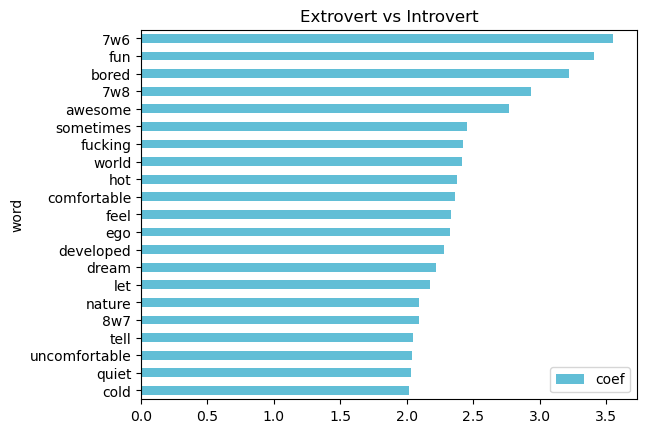

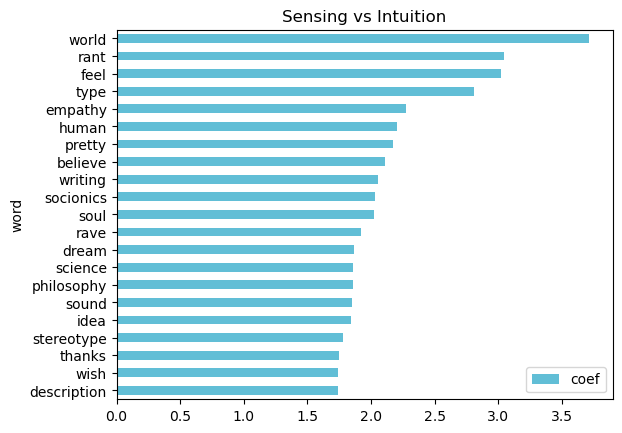

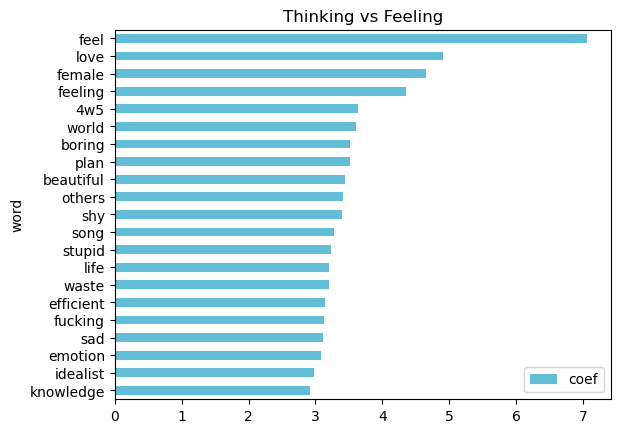

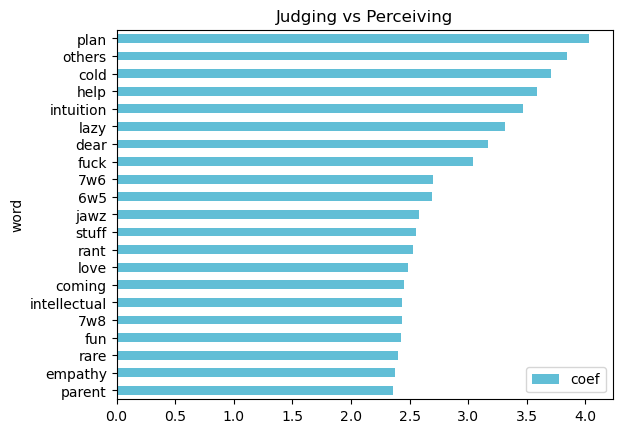

In [15]:
%%time

from sklearn.linear_model import LogisticRegressionCV
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from joblib import dump
import pandas as pd

# Assuming `y` is your target DataFrame and `X` is your feature DataFrame
# Also assuming `preprocesser_tf` and `mbti_type` are defined elsewhere in your code

for col in y.columns:
    print(f"\n{mbti_type[col]}")

    target = y[col]

    tfidf_logistic_regression = Pipeline([
        ('preprocessor', preprocesser_tf),
        ('under_sampler', RandomUnderSampler()),
        ('classifier', LogisticRegressionCV())
    ])

    # Training the data on entire dataset
    tfidf_logistic_regression.fit(X, target)

    # Feature importance
    coef = tfidf_logistic_regression.named_steps['classifier'].coef_[0]
    word = tfidf_logistic_regression.named_steps['preprocessor'].named_transformers_['tfidf'].get_feature_names_out()
    word_list = list(zip(word, coef))
    result = pd.DataFrame(word_list, columns=["word", "coef"]).set_index("word")
    result = result.reindex(result.coef.abs().sort_values(ascending=False).index)[0:21]
    print(result)

    # Plotting feature importance
    result["coef"] = result["coef"].apply(lambda x: abs(x))
    result.sort_values("coef", inplace=True)
    result.plot(kind="barh", color="#61BED6", title=mbti_type[col])

    # Saving the model
    dump(tfidf_logistic_regression, f"clf_{col}.joblib")
